In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_parquet("data/posts_reactions_df_topic_info.parquet")
# df["ds"] = pd.to_datetime(df["ds"])
df["ds"] = pd.to_datetime(df["date"])
df = df.sort_values(by="ds")
df["ds"] = df["ds"].dt.tz_localize(None)
df["date"] = df["date"].dt.tz_localize(None)

In [3]:
df = df.drop_duplicates(subset=['channel_name', 'message_id'], keep='last').reset_index()

In [4]:
df = df.drop(columns = ['index'])

In [61]:
# removed duplicates
# df.to_parquet('data/posts_reactions_df_topic_info_removed_duplicates.parquet', index=False)
# df_clean = pd.read_parquet('data/posts_reactions_df_topic_info_removed_duplicates.parquet')

In [5]:
df['Initial Primary Topic'].value_counts()

Initial Primary Topic
Geopolitical & War Dynamics                      1236
Environmental and Climate Issues                 1200
War-Related Environmental and Resource Impact    1012
Miscellaneous                                     759
Energy and Resources                              480
Name: count, dtype: int64

In [6]:
df['Initial Secondary Topic'].value_counts()

Initial Secondary Topic
War-Induced Environmental Issues           1012
War-Related Geopolitics                     742
Geopolitics (General)                       494
Water Resources                             416
Climate Change and Global Warming           362
Energy Issues                               327
Environmental Monitoring and Protection     236
Social and Internal Affairs                 218
Wildfires                                   186
Health and Safety                           163
Infrastructure and Resource Supply          153
Other                                       134
Emergency Response                          121
Art and Culture                              97
Economic and Job Related                     26
Name: count, dtype: int64

In [7]:
# constructing bool variables 
df['geopolitical_and_war_dynamics_presence'] = df['Initial Primary Topic'] == 'Geopolitical & War Dynamics'
df['env_and_climate_issues_presence'] = df['Initial Primary Topic'] == 'Environmental and Climate Issues'
df['war_related_environmental_and_resource_impact_presence'] = df['Initial Primary Topic'] == 'War-Related Environmental and Resource Impact'
df['energy_and_resources_presence'] = df['Initial Primary Topic'] == 'Energy and Resources'
df['critical_infrastructure_presence'] = df['Initial Secondary Topic'] == 'Infrastructure and Resource Supply'

# specifying additional variable for power outages (related to critical infrastructure)
df['power_outages_trend'] = df['trend']
df['power_outages_presence'] = df.trend.apply(lambda x: True if x > 3 else False)

In [7]:
# calculate pairwise frequencies not possible between primary topic groups since one document belongs to a single topic group.
# and there is little need since if I do it month-wise, the relationship will still be preserved

# df['war_dynamics_and_war_related_env_impact_presence'] = (df['geopolitical_and_war_dynamics_presence'] == True) & (df['war_related_environmental_and_resource_impact_presence'] == True)

# I can however do some with the power outages trend since it may occur independently of the primary topic group


In [8]:
topic_presence_variables = ['geopolitical_and_war_dynamics_presence', 'env_and_climate_issues_presence', 
                            'war_related_environmental_and_resource_impact_presence', 'energy_and_resources_presence',
                           'critical_infrastructure_presence']

for variable in topic_presence_variables:
    df[f'pairwise_{variable}_and_power_outages_presence'] = (df['power_outages_presence'] == True) & (df[variable] == True)

In [9]:
df.pairwise_critical_infrastructure_presence_and_power_outages_presence.value_counts()

pairwise_critical_infrastructure_presence_and_power_outages_presence
False    4624
True       63
Name: count, dtype: int64

In [10]:
df.power_outages_presence.value_counts()

power_outages_presence
False    3331
True     1356
Name: count, dtype: int64

In [11]:
df.columns[df.columns.str.startswith('pairwise')]

Index(['pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence',
       'pairwise_env_and_climate_issues_presence_and_power_outages_presence',
       'pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence',
       'pairwise_energy_and_resources_presence_and_power_outages_presence',
       'pairwise_critical_infrastructure_presence_and_power_outages_presence'],
      dtype='object')

In [12]:
def prepare_monthly_cooccurrence_data(document_data, date_column='date', min_docs_per_month=1):
    """
    Prepare monthly aggregated data for SEM analysis
    
    Parameters:
    -----------
    document_data : pd.DataFrame
        Document-level data with columns:
        - date_column: date information
        - war_dynamics: binary (0/1)
        - env_impact: binary (0/1) 
        - climate_issues: binary (0/1)
        - energy_resources: binary (0/1)
        - infrastructure: binary (0/1)
        - public_reaction: continuous
        
    Returns:
    --------
    pd.DataFrame: Monthly aggregated data ready for SEM
    """
    
    print("Preparing monthly co-occurrence data...")
    
    # Convert date column and extract year-month
    document_data[date_column] = pd.to_datetime(document_data[date_column])
    document_data['year_month'] = document_data[date_column].dt.to_period('M')
    
    # Define topic variables from your DAG
    topic_vars = ['geopolitical_and_war_dynamics_presence', 'env_and_climate_issues_presence',
                  'war_related_environmental_and_resource_impact_presence', 'energy_and_resources_presence',
                  'critical_infrastructure_presence', 'pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence',
                  'pairwise_env_and_climate_issues_presence_and_power_outages_presence',
                  'pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence',
                  'pairwise_energy_and_resources_presence_and_power_outages_presence',
                  'pairwise_critical_infrastructure_presence_and_power_outages_presence',
                  'power_outages_presence'
                 ]
    
    
    monthly_data = []
    
    # Process each month
    for month in document_data['year_month'].unique():
        month_docs = document_data[document_data['year_month'] == month]
        n_docs = len(month_docs)
        
        # Skip months with too few documents
        if n_docs < min_docs_per_month:
            print(f"Skipping {month}: only {n_docs} documents (min: {min_docs_per_month})")
            continue
        
        month_stats = {
            'year_month': str(month),
            'n_documents': n_docs
        }
        
        # 1. Individual topic frequencies
        for topic in topic_vars:
            freq = month_docs[topic].sum()
            month_stats[f'{topic}_freq'] = freq
            
        # 2. Pairwise co-occurrence frequencies  
        # for topic1, topic2 in cooccurrence_pairs:
        #     # Co-occurrence frequency (both topics present)
        #     cooccur_freq = ((month_docs[topic1] == 1) & 
        #                    (month_docs[topic2] == 1)).mean()
        #     month_stats[f'{topic1}_{topic2}_cooccur'] = cooccur_freq

        # 2. Power Outages Trend
        month_stats['power_outages_mean'] = month_docs['power_outages_trend'].mean()
        month_stats['power_outages_sum'] = month_docs['power_outages_trend'].sum()
        month_stats['power_outages_median'] = month_docs['power_outages_trend'].median()
            
        # 3. Public reaction measures
        month_stats['reaction_score_mean'] = month_docs['reactions_score'].mean()
        month_stats['reaction_score_std'] = month_docs['reactions_score'].std()
        month_stats['reaction_score_median'] = month_docs['reactions_score'].median()
        month_stats['reaction_score_sum'] = month_docs['reactions_score'].sum()
        
        # 4. Add temporal trend variable (months since start)
        month_stats['time_trend'] = len(monthly_data) + 1
        
        monthly_data.append(month_stats)
    
    # Convert to DataFrame
    result_df = pd.DataFrame(monthly_data)
    
    print(f"✓ Created {len(result_df)} monthly observations")
    print(f"✓ Date range: {result_df['year_month'].min()} to {result_df['year_month'].max()}")
    print(f"✓ Average documents per month: {result_df['n_documents'].mean():.1f}")
    
    return result_df

In [13]:
df_agg = prepare_monthly_cooccurrence_data(df, date_column='date', min_docs_per_month=1)

Preparing monthly co-occurrence data...
✓ Created 46 monthly observations
✓ Date range: 2020-05 to 2025-01
✓ Average documents per month: 101.9


In [14]:
df_agg

,year_month,n_documents,geopolitical_and_war_dynamics_presence_freq,env_and_climate_issues_presence_freq,war_related_environmental_and_resource_impact_presence_freq,energy_and_resources_presence_freq,critical_infrastructure_presence_freq,pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq,pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq,pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq,...,pairwise_critical_infrastructure_presence_and_power_outages_presence_freq,power_outages_presence_freq,power_outages_mean,power_outages_sum,power_outages_median,reaction_score_mean,reaction_score_std,reaction_score_median,reaction_score_sum,time_trend
0,2020-05,1,1,0,0,0,0,0,0,0,...,0,0,0.500000,0.5,0.5,1.000000,NaN,1.000000,1.000000,1
1,2020-10,2,0,2,0,0,0,0,0,0,...,0,0,0.500000,1.0,0.5,1.000000,0.000000,1.000000,2.000000,2
2,2021-02,1,0,0,0,0,0,0,0,0,...,0,0,0.500000,0.5,0.5,1.000000,NaN,1.000000,1.000000,3
3,2021-06,1,0,0,0,0,0,0,0,0,...,0,0,0.500000,0.5,0.5,1.000000,NaN,1.000000,1.000000,4
4,2021-07,3,0,1,0,0,0,0,0,0,...,0,0,0.500000,1.5,0.5,1.000000,0.000000,1.000000,3.000000,5
5,2021-08,4,0,2,0,0,0,0,0,0,...,0,0,0.375000,1.5,0.5,0.000000,1.154701,0.000000,0.000000,6
6,2021-09,2,1,0,0,0,0,0,0,0,...,0,0,0.500000,1.0,0.5,0.000000,1.414214,0.000000,0.000000,7
7,2021-10,1,0,0,0,0,0,0,0,0,...,0,0,0.500000,0.5,0.5,1.000000,NaN,1.000000,1.000000,8
8,2021-12,1,1,0,0,0,0,0,0,0,...,0,0,0.500000,0.5,0.5,1.000000,NaN,1.000000,1.000000,9
9,2022-01,4,1,0,0,0,0,0,0,0,...,0,0,0.500000,2.0,0.5,0.399784,0.939981,0.799569,1.599138,10


In [77]:
df_agg.drop(columns = ['reaction_score_std', 'year_month']).corr()

,n_documents,geopolitical_and_war_dynamics_presence_freq,env_and_climate_issues_presence_freq,war_related_environmental_and_resource_impact_presence_freq,energy_and_resources_presence_freq,critical_infrastructure_presence_freq,pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq,pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq,pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq,pairwise_energy_and_resources_presence_and_power_outages_presence_freq,pairwise_critical_infrastructure_presence_and_power_outages_presence_freq,power_outages_presence_freq,power_outages_mean,power_outages_sum,power_outages_median,reaction_score_mean,reaction_score_median,reaction_score_sum,time_trend
n_documents,1.000000,0.897195,0.842389,0.814559,0.592973,0.293008,0.355602,0.381280,0.363270,0.305706,0.165832,0.387701,0.356593,0.403808,0.299564,-0.664675,-0.518809,0.145032,0.740789
geopolitical_and_war_dynamics_presence_freq,0.897195,1.000000,0.638632,0.753030,0.435907,0.196962,0.487387,0.297522,0.394076,0.308958,0.158270,0.421827,0.461270,0.497030,0.400477,-0.602429,-0.430234,0.235456,0.800868
env_and_climate_issues_presence_freq,0.842389,0.638632,1.000000,0.489980,0.369836,0.174039,0.115454,0.346094,0.190665,0.173222,0.087754,0.217722,0.148287,0.202181,0.109252,-0.509197,-0.572614,-0.210500,0.503068
war_related_environmental_and_resource_impact_presence_freq,0.814559,0.753030,0.489980,1.000000,0.441584,0.125817,0.216358,0.182568,0.255066,0.096979,0.051360,0.215606,0.196553,0.232368,0.133445,-0.591722,-0.369540,0.301167,0.706498
energy_and_resources_presence_freq,0.592973,0.435907,0.369836,0.441584,1.000000,0.632214,0.426454,0.490602,0.420204,0.614124,0.379813,0.500089,0.473203,0.472590,0.433860,-0.405100,-0.146128,0.370352,0.343151
critical_infrastructure_presence_freq,0.293008,0.196962,0.174039,0.125817,0.632214,1.000000,0.225682,0.252162,0.250034,0.417814,0.633582,0.290753,0.173570,0.104108,0.136868,-0.236600,-0.067117,0.230462,0.136524
pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq,0.355602,0.487387,0.115454,0.216358,0.426454,0.225682,1.000000,0.708511,0.896307,0.814024,0.511128,0.943085,0.968486,0.931615,0.928524,-0.130244,0.041711,0.404645,0.470192
pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq,0.381280,0.297522,0.346094,0.182568,0.490602,0.252162,0.708511,1.000000,0.825046,0.806606,0.533465,0.891521,0.752325,0.762657,0.687129,-0.167234,-0.098349,0.169741,0.458877
pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq,0.363270,0.394076,0.190665,0.255066,0.420204,0.250034,0.896307,0.825046,1.000000,0.764895,0.525265,0.953607,0.871778,0.826128,0.813337,-0.144235,0.001131,0.380981,0.519931
pairwise_energy_and_resources_presence_and_power_outages_presence_freq,0.305706,0.308958,0.173222,0.096979,0.614124,0.417814,0.814024,0.806606,0.764895,1.000000,0.703853,0.887967,0.865449,0.816403,0.833682,-0.108611,0.057764,0.349774,0.342216


In [15]:
# high correlation, keep mean or power_outages_presence_freq
df_agg[['power_outages_mean', 'power_outages_sum', 'power_outages_median', 'power_outages_presence_freq']].corr()

,power_outages_mean,power_outages_sum,power_outages_median,power_outages_presence_freq
power_outages_mean,1.000000,0.969705,0.969655,0.940301
power_outages_sum,0.969705,1.000000,0.932031,0.912302
power_outages_median,0.969655,0.932031,1.000000,0.888170
power_outages_presence_freq,0.940301,0.912302,0.888170,1.000000


In [16]:
# I would suggest building a separate model for each variable and check where the strongest relationship lies
# I personally prefer mean and sum.
df_agg[['reaction_score_mean', 'reaction_score_std', 'reaction_score_median', 'reaction_score_sum']].fillna(0).corr()

,reaction_score_mean,reaction_score_std,reaction_score_median,reaction_score_sum
reaction_score_mean,1.000000,-0.877362,0.824886,0.086411
reaction_score_std,-0.877362,1.000000,-0.570875,0.128735
reaction_score_median,0.824886,-0.570875,1.000000,0.550666
reaction_score_sum,0.086411,0.128735,0.550666,1.000000


In [17]:
df_agg.columns

Index(['year_month', 'n_documents',
       'geopolitical_and_war_dynamics_presence_freq',
       'env_and_climate_issues_presence_freq',
       'war_related_environmental_and_resource_impact_presence_freq',
       'energy_and_resources_presence_freq',
       'critical_infrastructure_presence_freq',
       'pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq',
       'pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq',
       'pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq',
       'pairwise_energy_and_resources_presence_and_power_outages_presence_freq',
       'pairwise_critical_infrastructure_presence_and_power_outages_presence_freq',
       'power_outages_presence_freq', 'power_outages_mean',
       'power_outages_sum', 'power_outages_median', 'reaction_score_mean',
       'reaction_score_std', 'reaction_score_median', 'reaction_score_sum',
       'time_trend'],
      dtype='object')

In [18]:
# variables to be kept

x_variables = ['year_month', 'n_documents',
       'geopolitical_and_war_dynamics_presence_freq',
       'env_and_climate_issues_presence_freq',
       'war_related_environmental_and_resource_impact_presence_freq',
       'energy_and_resources_presence_freq',
       'critical_infrastructure_presence_freq',
       'pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq',
       'pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq',
       'pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq',
       'pairwise_energy_and_resources_presence_and_power_outages_presence_freq',
       'pairwise_critical_infrastructure_presence_and_power_outages_presence_freq',
       'power_outages_mean',
       'time_trend']

y_variables = ['reaction_score_mean', 'reaction_score_std', 'reaction_score_median', 'reaction_score_sum',]

In [19]:
def validate_monthly_data(monthly_df):
    """
    Quick validation and summary of monthly data
    """
    print("\n" + "="*50)
    print("MONTHLY DATA VALIDATION")
    print("="*50)
    
    # Basic info
    print(f"Number of months: {len(monthly_df)}")
    print(f"Date range: {monthly_df['year_month'].min()} to {monthly_df['year_month'].max()}")
    
    # Sample size distribution
    print(f"\nDocument counts per month:")
    print(f"  Mean: {monthly_df['n_documents'].mean():.1f}")
    print(f"  Min:  {monthly_df['n_documents'].min()}")
    print(f"  Max:  {monthly_df['n_documents'].max()}")
    
    # Co-occurrence frequency ranges
    cooccur_cols = [col for col in monthly_df.columns if 'pairwise_' in col]
    print(f"\nCo-occurrence frequency ranges:")
    for col in cooccur_cols:
        mean_val = monthly_df[col].mean()
        min_val = monthly_df[col].min()
        max_val = monthly_df[col].max()
        print(f"  {col:35}: {mean_val:.3f} (range: {min_val:.3f} - {max_val:.3f})")
    
    # Check for sufficient variation
    print(f"\nVariation check (std > 0.01):")
    for col in cooccur_cols:
        std_val = monthly_df[col].std()
        status = "✓" if std_val > 0.01 else "⚠"
        print(f"  {col:35}: {std_val:.4f} {status}")
    
    # Public reaction summary
    print(f"\nPublic reaction:")
    print(f"  Mean: {monthly_df['reaction_score_mean'].mean():.3f}")
    print(f"  Range: {monthly_df['reaction_score_mean'].min():.3f} - {monthly_df['reaction_score_mean'].max():.3f}")
    print(f"  Std: {monthly_df['reaction_score_mean'].std():.3f}")
    
    return True

def plot_monthly_trends(monthly_df):
    """
    Visualize monthly trends in co-occurrence patterns
    """
    # Convert year_month back to datetime for plotting
    monthly_df['date'] = pd.to_datetime(monthly_df['year_month'])
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Individual topic frequencies over time
    topic_freq_cols = [col for col in monthly_df.columns if col.endswith('_freq')]
    for col in topic_freq_cols:
        axes[0,0].plot(monthly_df['date'], monthly_df[col], 
                      marker='o', label=col.replace('_freq', ''), alpha=0.7)
    axes[0,0].set_title('Individual Topic Frequencies Over Time')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].legend()
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # # 2. Key co-occurrence frequencies over time
    # key_cooccur = ['war_dynamics_env_impact_cooccur', 
    #                'climate_issues_energy_resources_cooccur',
    #                'env_impact_infrastructure_cooccur']
    
    # for col in key_cooccur:
    #     if col in monthly_df.columns:
    #         axes[0,1].plot(monthly_df['date'], monthly_df[col], 
    #                       marker='s', label=col.replace('_cooccur', ''), alpha=0.7)
    # axes[0,1].set_title('Key Co-occurrence Frequencies Over Time')
    # axes[0,1].set_ylabel('Co-occurrence Frequency')
    # axes[0,1].legend()
    # axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Public reaction over time
    axes[1,0].plot(monthly_df['date'], monthly_df['reaction_score_mean'], 
                   marker='o', color='red', linewidth=2)
    axes[1,0].fill_between(monthly_df['date'], 
                          monthly_df['reaction_score_mean'] - monthly_df['reaction_score_std'],
                          monthly_df['reaction_score_mean'] + monthly_df['reaction_score_std'],
                          alpha=0.3, color='red')
    axes[1,0].set_title('Reaction Score Over Time (±1 SD)')
    axes[1,0].set_ylabel('Reaction Score')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # 4. Sample sizes over time
    axes[1,1].bar(monthly_df['date'], monthly_df['n_documents'], alpha=0.7, color='gray')
    axes[1,1].set_title('Number of Documents per Month')
    axes[1,1].set_ylabel('Document Count')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def create_correlation_matrix(monthly_df):
    """
    Create correlation matrix for the monthly data
    """
    # Select relevant variables for correlation
    analysis_vars = []
    
    # Individual frequencies
    freq_vars = [col for col in monthly_df.columns if col.endswith('_freq')]
    analysis_vars.extend(freq_vars)
    
    # Co-occurrence frequencies
    cooccur_vars = [col for col in monthly_df.columns if 'pairwise_' in col]
    analysis_vars.extend(cooccur_vars)
    
    # Public reaction
    analysis_vars.append('reaction_score_mean')
    
    # Create correlation matrix
    corr_matrix = monthly_df[analysis_vars].corr()
    
    # Plot heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.3f', cbar_kws={"shrink": .8})
    plt.title('Monthly Co-occurrence Data: Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

In [93]:
validate_monthly_data(df_agg)


MONTHLY DATA VALIDATION
Number of months: 46
Date range: 2020-05 to 2025-01

Document counts per month:
  Mean: 101.9
  Min:  1
  Max:  305

Co-occurrence frequency ranges:
  pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq: 8.304 (range: 0.000 - 60.000)
  pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq: 6.804 (range: 0.000 - 74.000)
  pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq: 5.739 (range: 0.000 - 39.000)
  pairwise_energy_and_resources_presence_and_power_outages_presence_freq: 3.826 (range: 0.000 - 33.000)
  pairwise_critical_infrastructure_presence_and_power_outages_presence_freq: 1.370 (range: 0.000 - 18.000)

Variation check (std > 0.01):
  pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq: 15.8589 ✓
  pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq: 15.1153 ✓
  pairwise_war_related_environmental_and_resource_impact_

True

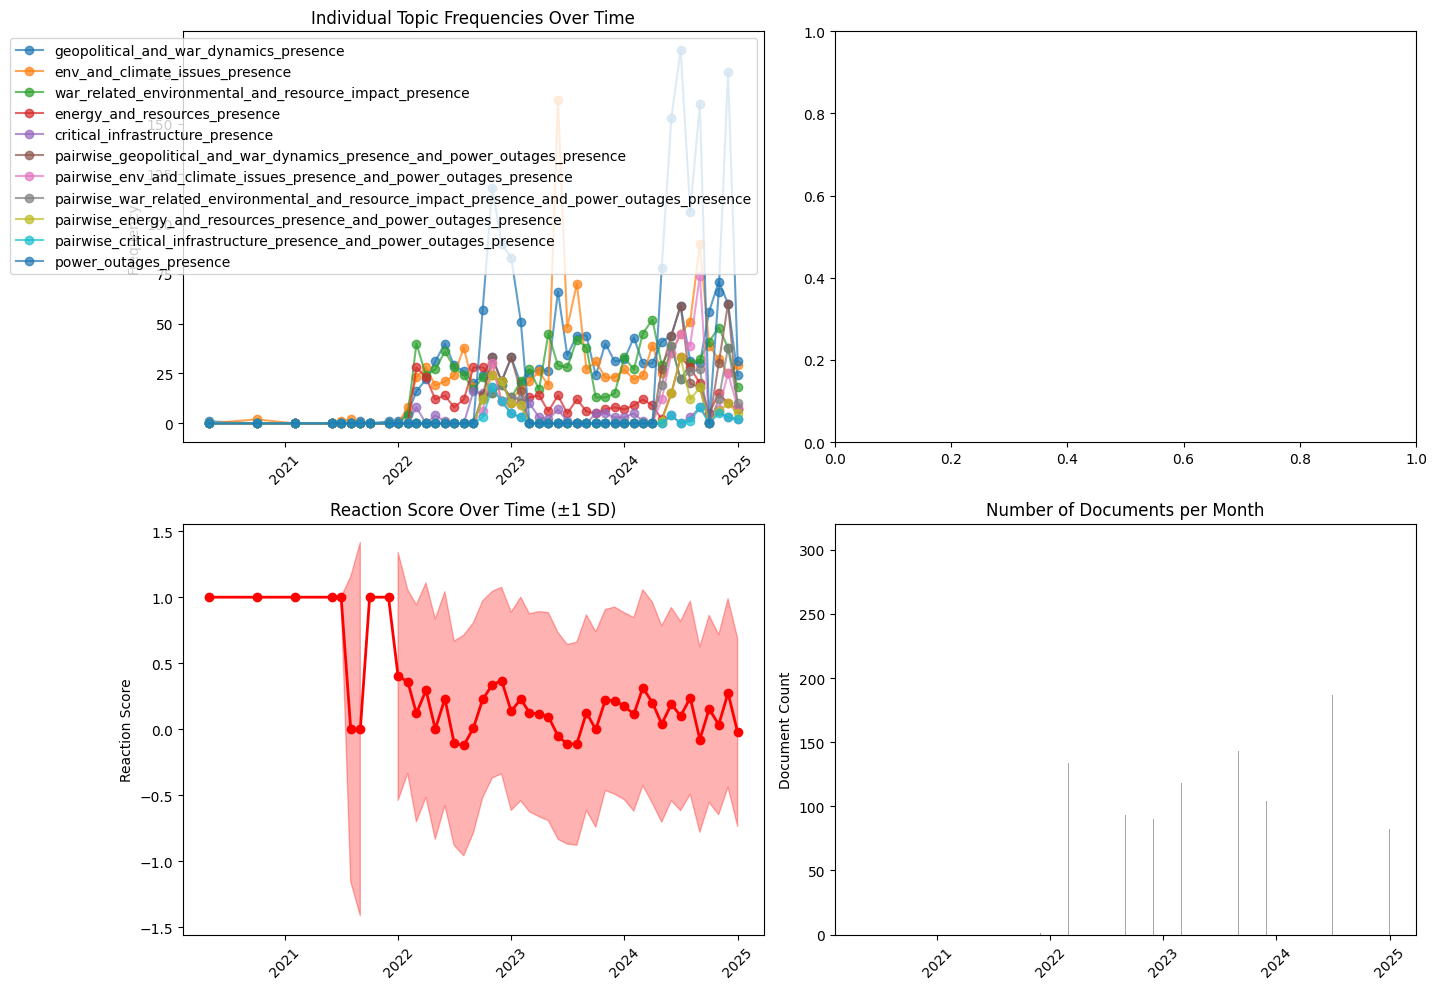

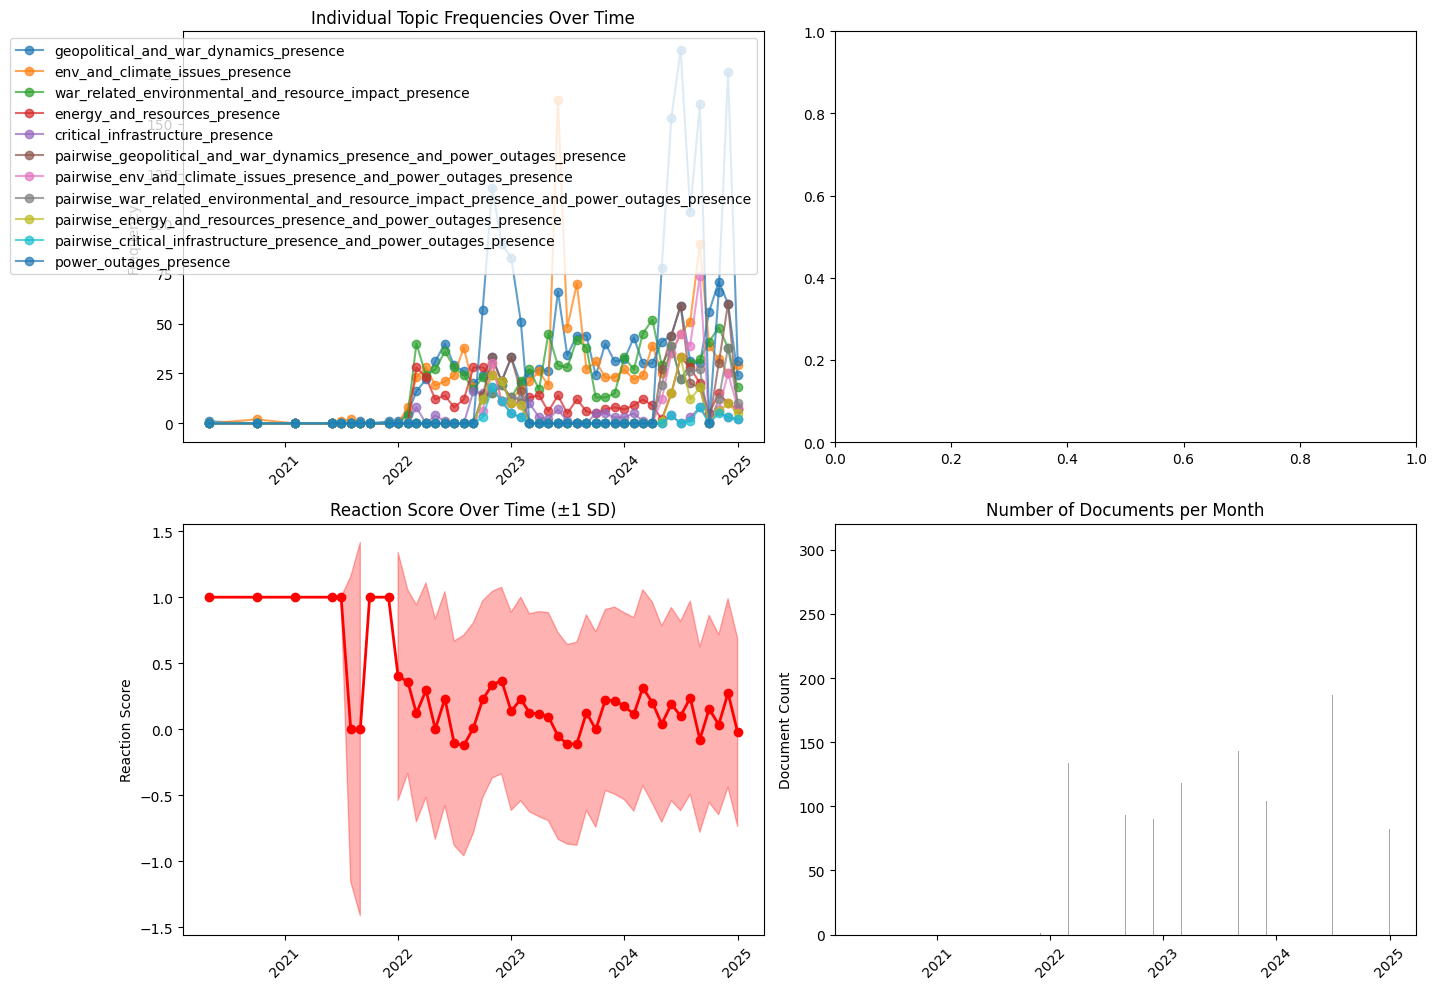

In [94]:
plot_monthly_trends(df_agg)

### SEM

In [20]:
import pandas as pd
import numpy as np
import semopy as sem
import matplotlib.pyplot as plt

In [21]:
# variables to be kept

x_variables = ['year_month', 'n_documents',
       'geopolitical_and_war_dynamics_presence_freq',
       'env_and_climate_issues_presence_freq',
       'war_related_environmental_and_resource_impact_presence_freq',
       'energy_and_resources_presence_freq',
       'critical_infrastructure_presence_freq',
       'pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq',
       'pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq',
       'pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq',
       'pairwise_energy_and_resources_presence_and_power_outages_presence_freq',
       'pairwise_critical_infrastructure_presence_and_power_outages_presence_freq',
       'power_outages_mean',
       'time_trend']

y_variables = ['reaction_score_mean', 'reaction_score_std', 'reaction_score_median', 'reaction_score_sum',]

In [48]:
class UkraineClimateSEM:
    """
    SEM Model Specification and Fitting for Ukraine Climate Study
    """
    
    def __init__(self, monthly_data):
        self.data = monthly_data
        self.models = {}
        self.fitted_models = {}
        
    def specify_base_model(self):
        """
        Specify the base SEM model based on your DAG diagram
        Updated for mutually exclusive topics + power outage co-occurrences
        """
        
        # Base model following your DAG structure
        base_model = """
        # Structural paths based on DAG relationships
        # Note: Topics are mutually exclusive, so we use frequencies + power outage co-occurrences
        
        # Power outage co-occurrences influenced by topic frequencies
        pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq ~ geopolitical_and_war_dynamics_presence_freq
        
        pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq ~ env_and_climate_issues_presence_freq  
        
        pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq ~ war_related_environmental_and_resource_impact_presence_freq
        
        pairwise_energy_and_resources_presence_and_power_outages_presence_freq ~ energy_and_resources_presence_freq
        
        pairwise_critical_infrastructure_presence_and_power_outages_presence_freq ~ critical_infrastructure_presence_freq
        
        # Cross-effects: One topic's frequency can influence another topic's power outage co-occurrence
        pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq ~ env_and_climate_issues_presence_freq + war_related_environmental_and_resource_impact_presence_freq + energy_and_resources_presence_freq
        
        pairwise_energy_and_resources_presence_and_power_outages_presence_freq ~ geopolitical_and_war_dynamics_presence_freq + env_and_climate_issues_presence_freq + war_related_environmental_and_resource_impact_presence_freq
        
        pairwise_critical_infrastructure_presence_and_power_outages_presence_freq ~ geopolitical_and_war_dynamics_presence_freq + env_and_climate_issues_presence_freq + war_related_environmental_and_resource_impact_presence_freq + energy_and_resources_presence_freq
        
        # Public Reaction influenced by topic frequencies and power outage co-occurrences
        
        reaction_score_mean ~ geopolitical_and_war_dynamics_presence_freq + war_related_environmental_and_resource_impact_presence_freq + env_and_climate_issues_presence_freq + energy_and_resources_presence_freq + critical_infrastructure_presence_freq + pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq + pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq + pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq + pairwise_energy_and_resources_presence_and_power_outages_presence_freq + pairwise_critical_infrastructure_presence_and_power_outages_presence_freq
        
        # Confounding relationships (covariances between topic frequencies)
        geopolitical_and_war_dynamics_presence_freq ~~ env_and_climate_issues_presence_freq
        geopolitical_and_war_dynamics_presence_freq ~~ war_related_environmental_and_resource_impact_presence_freq
        geopolitical_and_war_dynamics_presence_freq ~~ energy_and_resources_presence_freq

        war_related_environmental_and_resource_impact_presence_freq ~~ env_and_climate_issues_presence_freq
        war_related_environmental_and_resource_impact_presence_freq ~~ critical_infrastructure_presence_freq
        war_related_environmental_and_resource_impact_presence_freq ~~ energy_and_resources_presence_freq
        
        env_and_climate_issues_presence_freq ~~ energy_and_resources_presence_freq
        env_and_climate_issues_presence_freq ~~ war_related_environmental_and_resource_impact_presence_freq

        energy_and_resources_presence_freq ~~ critical_infrastructure_presence_freq
        critical_infrastructure_presence_freq ~~ energy_and_resources_presence_freq

        # Covariances between power outage co-occurrences
        pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq ~~ pairwise_energy_and_resources_presence_and_power_outages_presence_freq
        
        pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq ~~ pairwise_critical_infrastructure_presence_and_power_outages_presence_freq
        """
        
        self.models['base'] = base_model
        return base_model
    
    def specify_alternative_models(self):
        """
        Specify alternative models for comparison
        Updated for topic frequencies + power outage co-occurrences
        """
        
        # Model 1: Direct effects only (no cross-effects)
        direct_model = """
        # Direct effects of topic frequencies on public reaction
        reaction_score_mean ~ geopolitical_and_war_dynamics_presence_freq + war_related_environmental_and_resource_impact_presence_freq + env_and_climate_issues_presence_freq + energy_and_resources_presence_freq + critical_infrastructure_presence_freq
        
        # Direct effects of power outage co-occurrences on public reaction
        reaction_score_mean ~ pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq + pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq + pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq + pairwise_energy_and_resources_presence_and_power_outages_presence_freq + pairwise_critical_infrastructure_presence_and_power_outages_presence_freq
        
        # Power outages predicted only by their respective topics
        pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq ~ geopolitical_and_war_dynamics_presence_freq
        pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq ~ war_related_environmental_and_resource_impact_presence_freq
        pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq ~ env_and_climate_issues_presence_freq
        pairwise_energy_and_resources_presence_and_power_outages_presence_freq ~ energy_and_resources_presence_freq
        pairwise_critical_infrastructure_presence_and_power_outages_presence_freq ~ critical_infrastructure_presence_freq
        """
        
        # Model 2: Mediation model (power outages mediate topic effects)
        mediation_model = """
        # First stage: Topic frequencies influence power outage co-occurrences
        pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq ~ env_and_climate_issues_presence_freq + geopolitical_and_war_dynamics_presence_freq + war_related_environmental_and_resource_impact_presence_freq + energy_and_resources_presence_freq
        pairwise_energy_and_resources_presence_and_power_outages_presence_freq ~ energy_and_resources_presence_freq + critical_infrastructure_presence_freq
        pairwise_critical_infrastructure_presence_and_power_outages_presence_freq ~ geopolitical_and_war_dynamics_presence_freq + critical_infrastructure_presence_freq + war_related_environmental_and_resource_impact_presence_freq + energy_and_resources_presence_freq
        pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq ~ env_and_climate_issues_presence_freq
        pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq ~ war_related_environmental_and_resource_impact_presence_freq + env_and_climate_issues_presence_freq + geopolitical_and_war_dynamics_presence_freq
        
        # Second stage: Power outages influence public reaction (mediation)
        reaction_score_mean ~ pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq + pairwise_energy_and_resources_presence_and_power_outages_presence_freq + pairwise_critical_infrastructure_presence_and_power_outages_presence_freq + pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq + pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq
        
        # Direct effects (partial mediation)
        reaction_score_mean ~ geopolitical_and_war_dynamics_presence_freq + war_related_environmental_and_resource_impact_presence_freq + env_and_climate_issues_presence_freq + energy_and_resources_presence_freq + critical_infrastructure_presence_freq
        """
        
        # Model 3: Temporal model (with time trend)
        temporal_model = """
        # Power outage co-occurrences with cross-effects
        pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq ~ geopolitical_and_war_dynamics_presence_freq + env_and_climate_issues_presence_freq + war_related_environmental_and_resource_impact_presence_freq
        pairwise_energy_and_resources_presence_and_power_outages_presence_freq ~ energy_and_resources_presence_freq + geopolitical_and_war_dynamics_presence_freq
        pairwise_critical_infrastructure_presence_and_power_outages_presence_freq ~ critical_infrastructure_presence_freq + energy_and_resources_presence_freq
        pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq ~ war_related_environmental_and_resource_impact_presence_freq
        pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq ~ env_and_climate_issues_presence_freq
        
        # Public reaction with temporal trend
        reaction_score_mean ~ geopolitical_and_war_dynamics_presence_freq + war_related_environmental_and_resource_impact_presence_freq + env_and_climate_issues_presence_freq + energy_and_resources_presence_freq + critical_infrastructure_presence_freq + pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq + pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq + pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq + pairwise_energy_and_resources_presence_and_power_outages_presence_freq + pairwise_critical_infrastructure_presence_and_power_outages_presence_freq + time_trend
        """

        # Model 4: Custom (based on my knowledge)

        custom_model = """
        # War-related environmental impact
        war_related_environmental_and_resource_impact_presence_freq ~ geopolitical_and_war_dynamics_presence_freq + env_and_climate_issues_presence_freq + energy_and_resources_presence_freq

        war_related_environmental_and_resource_impact_presence_freq ~ geopolitical_and_war_dynamics_presence_freq + env_and_climate_issues_presence_freq + energy_and_resources_presence_freq + pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq + pairwise_energy_and_resources_presence_and_power_outages_presence_freq + pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq

        # Environmental and Climate Issues
        env_and_climate_issues_presence_freq ~ war_related_environmental_and_resource_impact_presence_freq + geopolitical_and_war_dynamics_presence_freq

        env_and_climate_issues_presence_freq ~ war_related_environmental_and_resource_impact_presence_freq + geopolitical_and_war_dynamics_presence_freq + pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq + pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq

        # Critical infrastructure
        critical_infrastructure_presence_freq ~ war_related_environmental_and_resource_impact_presence_freq + geopolitical_and_war_dynamics_presence_freq + energy_and_resources_presence_freq
        
        critical_infrastructure_presence_freq ~ war_related_environmental_and_resource_impact_presence_freq + pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq + geopolitical_and_war_dynamics_presence_freq + pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq + energy_and_resources_presence_freq + pairwise_energy_and_resources_presence_and_power_outages_presence_freq

        # Energy and Resources
        energy_and_resources_presence_freq ~ critical_infrastructure_presence_freq + geopolitical_and_war_dynamics_presence_freq
        energy_and_resources_presence_freq ~ critical_infrastructure_presence_freq + pairwise_critical_infrastructure_presence_and_power_outages_presence_freq + geopolitical_and_war_dynamics_presence_freq + pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq

        # Correlated
        energy_and_resources_presence_freq ~~ critical_infrastructure_presence_freq

        war_related_environmental_and_resource_impact_presence_freq ~~ env_and_climate_issues_presence_freq

        # Reaction Score
        reaction_score_mean ~ geopolitical_and_war_dynamics_presence_freq + war_related_environmental_and_resource_impact_presence_freq + env_and_climate_issues_presence_freq + energy_and_resources_presence_freq + critical_infrastructure_presence_freq + pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq + pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq + pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq + pairwise_energy_and_resources_presence_and_power_outages_presence_freq + pairwise_critical_infrastructure_presence_and_power_outages_presence_freq

        reaction_score_mean ~ geopolitical_and_war_dynamics_presence_freq + war_related_environmental_and_resource_impact_presence_freq + env_and_climate_issues_presence_freq + energy_and_resources_presence_freq + critical_infrastructure_presence_freq
        
        """


        custom_topic_only_model = """
        # War-related environmental impact
        war_related_environmental_and_resource_impact_presence_freq ~ geopolitical_and_war_dynamics_presence_freq + env_and_climate_issues_presence_freq + energy_and_resources_presence_freq

        # Environmental and Climate Issues
        env_and_climate_issues_presence_freq ~ war_related_environmental_and_resource_impact_presence_freq + geopolitical_and_war_dynamics_presence_freq

        # Critical infrastructure
        critical_infrastructure_presence_freq ~ war_related_environmental_and_resource_impact_presence_freq + geopolitical_and_war_dynamics_presence_freq + energy_and_resources_presence_freq
        
        # Energy and Resources
        energy_and_resources_presence_freq ~ critical_infrastructure_presence_freq + geopolitical_and_war_dynamics_presence_freq
      
        # Correlated
        energy_and_resources_presence_freq ~~ critical_infrastructure_presence_freq

        war_related_environmental_and_resource_impact_presence_freq ~~ env_and_climate_issues_presence_freq

        geopolitical_and_war_dynamics_presence_freq ~~ env_and_climate_issues_presence_freq

        """

        custom_power_outage = """
        # War-related environmental impact
        pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq ~ war_related_environmental_and_resource_impact_presence_freq + geopolitical_and_war_dynamics_presence_freq + env_and_climate_issues_presence_freq + energy_and_resources_presence_freq

        # Environmental and Climate Issues
        pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq ~ env_and_climate_issues_presence_freq + war_related_environmental_and_resource_impact_presence_freq + geopolitical_and_war_dynamics_presence_freq + energy_and_resources_presence_freq

        # Critical infrastructure
        pairwise_critical_infrastructure_presence_and_power_outages_presence_freq ~ critical_infrastructure_presence_freq + geopolitical_and_war_dynamics_presence_freq + energy_and_resources_presence_freq
        
        # Correlated
        energy_and_resources_presence_freq ~~ geopolitical_and_war_dynamics_presence_freq
        energy_and_resources_presence_freq ~~ critical_infrastructure_presence_freq
        energy_and_resources_presence_freq ~~ env_and_climate_issues_presence_freq
        war_related_environmental_and_resource_impact_presence_freq ~~ env_and_climate_issues_presence_freq

        """

        custom_pairwise_model = """
        # Reaction Score
        reaction_score_sum ~ geopolitical_and_war_dynamics_presence_freq + war_related_environmental_and_resource_impact_presence_freq + env_and_climate_issues_presence_freq + energy_and_resources_presence_freq + critical_infrastructure_presence_freq + pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq + pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq + pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq + pairwise_energy_and_resources_presence_and_power_outages_presence_freq + pairwise_critical_infrastructure_presence_and_power_outages_presence_freq

        reaction_score_mean ~ geopolitical_and_war_dynamics_presence_freq + war_related_environmental_and_resource_impact_presence_freq + env_and_climate_issues_presence_freq + energy_and_resources_presence_freq + critical_infrastructure_presence_freq + pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq + pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq + pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq + pairwise_energy_and_resources_presence_and_power_outages_presence_freq + pairwise_critical_infrastructure_presence_and_power_outages_presence_freq

        reaction_score_median ~ geopolitical_and_war_dynamics_presence_freq + war_related_environmental_and_resource_impact_presence_freq + env_and_climate_issues_presence_freq + energy_and_resources_presence_freq + critical_infrastructure_presence_freq + pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq + pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq + pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq + pairwise_energy_and_resources_presence_and_power_outages_presence_freq + pairwise_critical_infrastructure_presence_and_power_outages_presence_freq
        
        """

        custom_without_pairs_model = """
        # Reaction Score
        reaction_score_median ~ geopolitical_and_war_dynamics_presence_freq + war_related_environmental_and_resource_impact_presence_freq + env_and_climate_issues_presence_freq + energy_and_resources_presence_freq + critical_infrastructure_presence_freq
        reaction_score_mean ~ geopolitical_and_war_dynamics_presence_freq + war_related_environmental_and_resource_impact_presence_freq + env_and_climate_issues_presence_freq + energy_and_resources_presence_freq + critical_infrastructure_presence_freq
        reaction_score_sum ~ geopolitical_and_war_dynamics_presence_freq + war_related_environmental_and_resource_impact_presence_freq + env_and_climate_issues_presence_freq + energy_and_resources_presence_freq + critical_infrastructure_presence_freq
        
        """
        
        self.models.update({
            'direct': direct_model,
            'mediation': mediation_model,
            'temporal': temporal_model,
            'custom_mean': custom_model,
            'custom_pairwise': custom_pairwise_model,
            'custom_without_pairs': custom_without_pairs_model,
            'custom_topic_only': custom_topic_only_model,
            'custom_power_outage': custom_power_outage
        })
        
        return self.models
    
    def test_multiple_outcomes(self):
        """
        Test models with different reaction score aggregations
        Updated for power outage co-occurrences
        """
        
        outcome_models = {}
        
        # Test with different outcome measures
        for outcome in ['reaction_score_mean', 'reaction_score_sum', 'reaction_score_median']:
            
            if outcome in self.data.columns:
                model_spec = f"""
                # Main structural model with {outcome} as outcome
                
                # Power outage co-occurrences predicted by topic frequencies
                pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq ~ geopolitical_and_war_dynamics_presence_freq
                pairwise_energy_and_resources_presence_and_power_outages_presence_freq ~ energy_and_resources_presence_freq
                pairwise_critical_infrastructure_presence_and_power_outages_presence_freq ~ critical_infrastructure_presence_freq
                pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq ~ war_related_environmental_and_resource_impact_presence_freq
                pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq ~ env_and_climate_issues_presence_freq
        
                
                # Cross-effects between topics and power outages
                war_dynamics_power_outage_cooccur ~ climate_issues_freq + energy_resources_freq
                energy_resources_power_outage_cooccur ~ war_dynamics_freq + climate_issues_freq
                infrastructure_power_outage_cooccur ~ war_dynamics_freq + energy_resources_freq
                
                # Outcome prediction
                {outcome} ~ geopolitical_and_war_dynamics_presence_freq + war_related_environmental_and_resource_impact_presence_freq + env_and_climate_issues_presence_freq + energy_and_resources_presence_freq + critical_infrastructure_presence_freq + pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq + pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq + pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq + pairwise_energy_and_resources_presence_and_power_outages_presence_freq + pairwise_critical_infrastructure_presence_and_power_outages_presence_freq +

                # Confounding
                geopolitical_and_war_dynamics_presence_freq ~~ env_and_climate_issues_presence_freq
                pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq ~~ pairwise_energy_and_resources_presence_and_power_outages_presence_freq

                geopolitical_and_war_dynamics_presence_freq ~~ energy_and_resources_presence_freq
                
                war_related_environmental_and_resource_impact_presence_freq ~~ critical_infrastructure_presence_freq
                
                war_related_environmental_and_resource_impact_presence_freq ~~ energy_and_resources_presence_freq

                war_related_environmental_and_resource_impact_presence_freq ~~ env_and_climate_issues_presence_freq
                
                env_and_climate_issues_presence_freq ~~ energy_and_resources_presence_freq
                
                env_and_climate_issues_presence_freq ~~ war_related_environmental_and_resource_impact_presence_freq

                """
                
                outcome_models[outcome] = model_spec
        
        self.models.update(outcome_models)
        return outcome_models
    
    def fit_model(self, model_name='base'):
        """
        Fit specified SEM model
        """
        
        if model_name not in self.models:
            raise ValueError(f"Model '{model_name}' not specified. Available: {list(self.models.keys())}")
        
        print(f"\nFitting {model_name} model...")
        
        try:
            # Create semopy model
            model = sem.Model(self.models[model_name])
            
            # Load data
            model.load_dataset(self.data)
            
            # Fit model
            optimizer = sem.Optimizer(model)
            objective_value = optimizer.optimize()
            
            # Store fitted model
            self.fitted_models[model_name] = {
                'model': model,
                'optimizer': optimizer,
                'objective_value': objective_value
            }
            
            print(f"✓ {model_name} model fitted successfully")
            print(f"  Objective value: {objective_value:.6f}")
            
            return optimizer
            
        except Exception as e:
            print(f"✗ Error fitting {model_name} model: {e}")
            return None
    
    def compare_models(self):
        """
        Compare fit statistics across different models
        """
        
        if not self.fitted_models:
            print("No fitted models available. Fit models first.")
            return
        
        print("\n" + "="*60)
        print("MODEL COMPARISON")
        print("="*60)
        
        comparison_stats = []
        
        for model_name, fitted_info in self.fitted_models.items():
            try:
                optimizer = fitted_info['optimizer'].model
                fit_stats = sem.calc_stats(optimizer)
                
                stats_dict = {
                    'Model': model_name,
                    'Chi-square': fit_stats.loc['Value', 'chi2'],
                    'DoF': fit_stats.loc['Value', 'DoF'],
                    'p-value': fit_stats.loc['Value', 'chi2 p-value'],
                    'CFI': fit_stats.loc['Value', 'CFI'],
                    'TLI': fit_stats.loc['Value', 'TLI'],
                    'RMSEA': fit_stats.loc['Value', 'RMSEA'],
                    'AIC': fit_stats.loc['Value', 'AIC'],
                    'BIC': fit_stats.loc['Value', 'BIC']
                }
        
                
                comparison_stats.append(stats_dict)
                
            except Exception as e:
                print(f"Error calculating stats for {model_name}: {e}")
        
        # Create comparison DataFrame
        comparison_df = pd.DataFrame(comparison_stats)
        
        # Display comparison
        print("\nFit Statistics Comparison:")
        print(comparison_df.round(3))
        
        # Highlight best models
        if len(comparison_df) > 1:
            print(f"\nBest fit indicators:")
            print(f"Lowest AIC: {comparison_df.loc[comparison_df['AIC'].idxmin(), 'Model']}")
            print(f"Lowest BIC: {comparison_df.loc[comparison_df['BIC'].idxmin(), 'Model']}")
            print(f"Highest CFI: {comparison_df.loc[comparison_df['CFI'].idxmax(), 'Model']}")
        
        return comparison_df
    
    def print_results(self, model_name='base'):
        """
        Print detailed results for specified model
        """
        
        if model_name not in self.fitted_models:
            print(f"Model '{model_name}' not fitted yet.")
            return
        
        optimizer = self.fitted_models[model_name]['optimizer'].model
        
        # Get parameter estimates
        # print(dir(optimizer))
        estimates = optimizer.inspect()
        estimates_df = pd.DataFrame(estimates)
        
        print(f"\n" + "="*60)
        print(f"DETAILED RESULTS: {model_name.upper()} MODEL")
        print("="*60)
        
        # Structural paths
        print(f"\nSTRUCTURAL PATHS:")
        print("-" * 40)
        
        structural_paths = estimates_df[estimates_df['op'].str.contains('~') & 
                                      ~estimates_df['op'].str.contains('~~')]
        
        for _, row in structural_paths.iterrows():
            coef = row['Estimate']
            se = row['Std. Err']
            p_val = row['p-value']
            
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            effect_size = "Large" if abs(coef) > 0.5 else "Medium" if abs(coef) > 0.3 else "Small"
            
            print(f"{row['lval']:50} ~ {row['rval']:50} = {coef:7.4f} (SE: {se:6.4f}, p: {p_val:6.4f}){significance:3} [{effect_size}]")
        
        # Get fit statistics
        fit_stats = sem.calc_stats(optimizer)
        
        print(f"\nMODEL FIT STATISTICS:")
        print("-" * 40)
        print(f"Chi-square: {fit_stats.loc['Value', 'chi2']:8.4f}")
        print(f"DoF:        {fit_stats.loc['Value', 'DoF']:8.0f}")
        print(f"p-value:    {fit_stats.loc['Value', 'chi2 p-value']:8.4f}")
        print(f"CFI:        {fit_stats.loc['Value', 'CFI']:8.4f}")
        print(f"TLI:        {fit_stats.loc['Value', 'TLI']:8.4f}")
        print(f"RMSEA:      {fit_stats.loc['Value', 'RMSEA']:8.4f}")
        print(f"AIC:        {fit_stats.loc['Value', 'AIC']:8.4f}")
        print(f"BIC:        {fit_stats.loc['Value', 'BIC']:8.4f}")
        
        # Interpretation
        cfi = fit_stats.loc['Value', 'CFI']
        tli = fit_stats.loc['Value', 'TLI']
        rmsea = fit_stats.loc['Value', 'RMSEA']
        
        print(f"\nMODEL FIT INTERPRETATION:")
        print("-" * 40)
        print(f"CFI ≥ 0.95:   {'✓' if cfi >= 0.95 else '✗'} ({cfi:.3f})")
        print(f"TLI ≥ 0.95:   {'✓' if tli >= 0.95 else '✗'} ({tli:.3f})")
        print(f"RMSEA ≤ 0.06: {'✓' if rmsea <= 0.06 else '✗'} ({rmsea:.3f})")
        
        if cfi >= 0.95 and tli >= 0.95 and rmsea <= 0.06:
            print("Overall fit: EXCELLENT")
        elif cfi >= 0.90 and tli >= 0.90 and rmsea <= 0.08:
            print("Overall fit: GOOD")
        else:
            print("Overall fit: NEEDS IMPROVEMENT")
        
        return estimates_df, fit_stats

def main_sem_workflow(monthly_data):
    """
    Complete SEM workflow
    """
    
    print("SEM ANALYSIS WORKFLOW")
    print("="*50)
    
    # Initialize SEM analysis
    sem_analysis = UkraineClimateSEM(monthly_data)
    
    # Step 1: Specify models
    print("\n1. Specifying SEM models...")
    base_model = sem_analysis.specify_base_model()
    alternative_models = sem_analysis.specify_alternative_models()
    outcome_models = sem_analysis.test_multiple_outcomes()
    
    print(f"✓ Specified {len(sem_analysis.models)} models")

    
    # Step 2: Fit models
    print("\n2. Fitting models...")
    for model_name in ['base', 'direct', 'mediation', 'custom_mean', 'custom_pairwise', 'custom_without_pairs', 'temporal', 'custom_power_outage', 'custom_topic_only']:
        sem_analysis.fit_model(model_name)


    print(sem_analysis.fitted_models)
    
    # Step 3: Compare models
    print("\n3. Comparing models...")
    comparison_df = sem_analysis.compare_models()
    
    # Step 4: Detailed results for best model
    print("\n4. Detailed results...")
    sem_analysis.print_results('base')
    
    return sem_analysis

# Example usage
if __name__ == "__main__":
    # Assuming you have your monthly_data ready
    print("This script requires your validated monthly_data DataFrame")
    print("Usage: sem_analysis = main_sem_workflow(your_monthly_data)")
    sem_analysis = main_sem_workflow(df_agg)

This script requires your validated monthly_data DataFrame
Usage: sem_analysis = main_sem_workflow(your_monthly_data)
SEM ANALYSIS WORKFLOW

1. Specifying SEM models...
✓ Specified 12 models

2. Fitting models...

Fitting base model...
✓ base model fitted successfully
  Objective value: 4.239743

Fitting direct model...
✓ direct model fitted successfully
  Objective value: 6.120586

Fitting mediation model...
✓ mediation model fitted successfully
  Objective value: 5.651812

Fitting custom_mean model...
✓ custom_mean model fitted successfully
  Objective value: 0.317417

Fitting custom_pairwise model...
✓ custom_pairwise model fitted successfully
  Objective value: 2.295042

Fitting custom_without_pairs model...
✓ custom_without_pairs model fitted successfully
  Objective value: 2.307043

Fitting temporal model...
✓ temporal model fitted successfully
  Objective value: 6.463966

Fitting custom_power_outage model...
✓ custom_power_outage model fitted successfully
  Objective value: 1.38

/Users/Taras_Ustyianovych/workspace/python-envs/tg-data-research/lib/python3.9/site-packages/semopy/stats.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((chi2 / dof - 1) / (model.n_samples - 1))



Fit Statistics Comparison:
                  Model  Chi-square  DoF  p-value    CFI    TLI  RMSEA  \
0                  base     195.028   23    0.000  0.589 -0.072  0.408   
1                direct     281.547   45    0.000  0.435  0.247  0.342   
2             mediation     259.983   36    0.000  0.465  0.108  0.372   
3           custom_mean      14.601   29    0.988  1.034  1.073  0.000   
4       custom_pairwise     105.572   58    0.000  0.914  0.869  0.135   
5  custom_without_pairs     106.124   18    0.000  0.643  0.345  0.330   
6              temporal     297.342   52    0.000  0.492  0.297  0.324   
7   custom_power_outage      63.688   18    0.000  0.771  0.580  0.237   
8     custom_topic_only       0.078   -2      NaN  0.977  1.127    NaN   

      AIC      BIC  
0  77.521  156.152  
1  29.759   68.160  
2  48.696  103.556  
3  73.365  141.025  
4  61.410  121.755  
5  31.386   64.301  
6  39.072   86.617  
7  33.231   66.146  
8  33.997   65.084  

Best fit indicators:

In [53]:
sem_analysis.fitted_models

{'base': {'model': <semopy.model.Model at 0x30aa3ab80>,
  'optimizer': <semopy.optimizer.Optimizer at 0x30aa3ab20>,
  'objective_value': 4.2397427780641905},
 'direct': {'model': <semopy.model.Model at 0x30a750d60>,
  'optimizer': <semopy.optimizer.Optimizer at 0x300e695e0>,
  'objective_value': 6.1205860674474195},
 'mediation': {'model': <semopy.model.Model at 0x30e009100>,
  'optimizer': <semopy.optimizer.Optimizer at 0x30e06c790>,
  'objective_value': 5.651812354988131},
 'custom_mean': {'model': <semopy.model.Model at 0x30e943760>,
  'optimizer': <semopy.optimizer.Optimizer at 0x30e8aef70>,
  'objective_value': 0.3174172085705358},
 'custom_pairwise': {'model': <semopy.model.Model at 0x30eae2760>,
  'optimizer': <semopy.optimizer.Optimizer at 0x30e9cbbb0>,
  'objective_value': 2.2950417271128565},
 'custom_without_pairs': {'model': <semopy.model.Model at 0x30aa18bb0>,
  'optimizer': <semopy.optimizer.Optimizer at 0x30e969610>,
  'objective_value': 2.3070426387944636},
 'temporal':

### Direct model

In [49]:
sem_analysis.print_results(model_name='direct')


DETAILED RESULTS: DIRECT MODEL

STRUCTURAL PATHS:
----------------------------------------
pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq ~ geopolitical_and_war_dynamics_presence_freq        =  0.4078 (SE: 0.1076, p: 0.0002)*** [Medium]
pairwise_war_related_environmental_and_resource_impact_presence_and_power_outages_presence_freq ~ war_related_environmental_and_resource_impact_presence_freq =  0.1733 (SE: 0.0967, p: 0.0730)    [Small]
pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq ~ env_and_climate_issues_presence_freq               =  0.1892 (SE: 0.0756, p: 0.0124)*   [Small]
pairwise_energy_and_resources_presence_and_power_outages_presence_freq ~ energy_and_resources_presence_freq                 =  0.5069 (SE: 0.0961, p: 0.0000)*** [Large]
pairwise_critical_infrastructure_presence_and_power_outages_presence_freq ~ critical_infrastructure_presence_freq              =  0.4745 (SE: 0.0854, p: 0.0000)*** [Medium]
reaction_scor

(                                                 lval  op  \
 0   pairwise_geopolitical_and_war_dynamics_presenc...   ~   
 1   pairwise_war_related_environmental_and_resourc...   ~   
 2   pairwise_env_and_climate_issues_presence_and_p...   ~   
 3   pairwise_energy_and_resources_presence_and_pow...   ~   
 4   pairwise_critical_infrastructure_presence_and_...   ~   
 5                                 reaction_score_mean   ~   
 6                                 reaction_score_mean   ~   
 7                                 reaction_score_mean   ~   
 8                                 reaction_score_mean   ~   
 9                                 reaction_score_mean   ~   
 10                                reaction_score_mean   ~   
 11                                reaction_score_mean   ~   
 12                                reaction_score_mean   ~   
 13                                reaction_score_mean   ~   
 14                                reaction_score_mean   ~   
 15  pai

### Mediation model

In [50]:
sem_analysis.print_results(model_name='mediation')


DETAILED RESULTS: MEDIATION MODEL

STRUCTURAL PATHS:
----------------------------------------
pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq ~ env_and_climate_issues_presence_freq               = -0.2184 (SE: 0.0822, p: 0.0079)**  [Small]
pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq ~ geopolitical_and_war_dynamics_presence_freq        =  0.7520 (SE: 0.1582, p: 0.0000)*** [Large]
pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq ~ war_related_environmental_and_resource_impact_presence_freq = -0.4460 (SE: 0.1730, p: 0.0099)**  [Medium]
pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq ~ energy_and_resources_presence_freq                 =  0.6328 (SE: 0.2145, p: 0.0032)**  [Large]
pairwise_energy_and_resources_presence_and_power_outages_presence_freq ~ energy_and_resources_presence_freq                 =  0.4813 (SE: 0.1238, p: 0.0001)*** [Medium]
pairwise_ener

(                                                 lval  op  \
 0   pairwise_geopolitical_and_war_dynamics_presenc...   ~   
 1   pairwise_geopolitical_and_war_dynamics_presenc...   ~   
 2   pairwise_geopolitical_and_war_dynamics_presenc...   ~   
 3   pairwise_geopolitical_and_war_dynamics_presenc...   ~   
 4   pairwise_energy_and_resources_presence_and_pow...   ~   
 5   pairwise_energy_and_resources_presence_and_pow...   ~   
 6   pairwise_critical_infrastructure_presence_and_...   ~   
 7   pairwise_critical_infrastructure_presence_and_...   ~   
 8   pairwise_critical_infrastructure_presence_and_...   ~   
 9   pairwise_critical_infrastructure_presence_and_...   ~   
 10  pairwise_env_and_climate_issues_presence_and_p...   ~   
 11  pairwise_war_related_environmental_and_resourc...   ~   
 12  pairwise_war_related_environmental_and_resourc...   ~   
 13  pairwise_war_related_environmental_and_resourc...   ~   
 14                                reaction_score_mean   ~   
 15     

### Temporal model

In [51]:
sem_analysis.print_results(model_name='temporal')


DETAILED RESULTS: TEMPORAL MODEL

STRUCTURAL PATHS:
----------------------------------------
pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq ~ geopolitical_and_war_dynamics_presence_freq        =  0.7967 (SE: 0.1720, p: 0.0000)*** [Large]
pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq ~ env_and_climate_issues_presence_freq               = -0.1866 (SE: 0.0890, p: 0.0359)*   [Small]
pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq ~ war_related_environmental_and_resource_impact_presence_freq = -0.3487 (SE: 0.1855, p: 0.0601)    [Medium]
pairwise_energy_and_resources_presence_and_power_outages_presence_freq ~ energy_and_resources_presence_freq                 =  0.4885 (SE: 0.1066, p: 0.0000)*** [Medium]
pairwise_energy_and_resources_presence_and_power_outages_presence_freq ~ geopolitical_and_war_dynamics_presence_freq        =  0.0205 (SE: 0.0519, p: 0.6929)    [Small]
pairwise_critical_infra

(                                                 lval  op  \
 0   pairwise_geopolitical_and_war_dynamics_presenc...   ~   
 1   pairwise_geopolitical_and_war_dynamics_presenc...   ~   
 2   pairwise_geopolitical_and_war_dynamics_presenc...   ~   
 3   pairwise_energy_and_resources_presence_and_pow...   ~   
 4   pairwise_energy_and_resources_presence_and_pow...   ~   
 5   pairwise_critical_infrastructure_presence_and_...   ~   
 6   pairwise_critical_infrastructure_presence_and_...   ~   
 7   pairwise_war_related_environmental_and_resourc...   ~   
 8   pairwise_env_and_climate_issues_presence_and_p...   ~   
 9                                 reaction_score_mean   ~   
 10                                reaction_score_mean   ~   
 11                                reaction_score_mean   ~   
 12                                reaction_score_mean   ~   
 13                                reaction_score_mean   ~   
 14                                reaction_score_mean   ~   
 15     

### Custom Mean Model

In [52]:
sem_analysis.print_results(model_name='custom_mean')


DETAILED RESULTS: CUSTOM_MEAN MODEL

STRUCTURAL PATHS:
----------------------------------------
war_related_environmental_and_resource_impact_presence_freq ~ geopolitical_and_war_dynamics_presence_freq        =  0.4144 (SE: 0.2515, p: 0.0994)    [Medium]
war_related_environmental_and_resource_impact_presence_freq ~ env_and_climate_issues_presence_freq               = -0.1471 (SE: 0.3819, p: 0.7001)    [Small]
war_related_environmental_and_resource_impact_presence_freq ~ energy_and_resources_presence_freq                 =  2.2957 (SE: 1.4265, p: 0.1075)    [Large]
war_related_environmental_and_resource_impact_presence_freq ~ pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq =  0.2700 (SE: 0.3108, p: 0.3851)    [Small]
war_related_environmental_and_resource_impact_presence_freq ~ pairwise_energy_and_resources_presence_and_power_outages_presence_freq = -2.7888 (SE: 1.4806, p: 0.0596)    [Large]
war_related_environmental_and_resource_impact_presence_freq ~ p

(                                                 lval  op  \
 0   war_related_environmental_and_resource_impact_...   ~   
 1   war_related_environmental_and_resource_impact_...   ~   
 2   war_related_environmental_and_resource_impact_...   ~   
 3   war_related_environmental_and_resource_impact_...   ~   
 4   war_related_environmental_and_resource_impact_...   ~   
 5   war_related_environmental_and_resource_impact_...   ~   
 6                env_and_climate_issues_presence_freq   ~   
 7                env_and_climate_issues_presence_freq   ~   
 8                env_and_climate_issues_presence_freq   ~   
 9                env_and_climate_issues_presence_freq   ~   
 10              critical_infrastructure_presence_freq   ~   
 11              critical_infrastructure_presence_freq   ~   
 12              critical_infrastructure_presence_freq   ~   
 13              critical_infrastructure_presence_freq   ~   
 14              critical_infrastructure_presence_freq   ~   
 15     

In [28]:
sem_analysis.print_results(model_name='custom_sum')


DETAILED RESULTS: CUSTOM_SUM MODEL

STRUCTURAL PATHS:
----------------------------------------
reaction_score_sum                                 =  0.2895 (SE: 0.2392, p: 0.2262)    [Small]
reaction_score_sum                                 =  0.1663 (SE: 0.2248, p: 0.4596)    [Small]
reaction_score_sum                                 = -0.3631 (SE: 0.1087, p: 0.0008)*** [Medium]
reaction_score_sum                                 =  0.7502 (SE: 0.4163, p: 0.0715)    [Large]
reaction_score_sum                                 = -0.6836 (SE: 0.7427, p: 0.3574)    [Large]
reaction_score_sum                                 = -0.3836 (SE: 0.4125, p: 0.3524)    [Medium]
reaction_score_sum                                 =  0.9999 (SE: 0.5465, p: 0.0673)    [Large]
reaction_score_sum                                 = -0.4388 (SE: 0.2896, p: 0.1297)    [Medium]
reaction_score_sum                                 =  0.3020 (SE: 0.7536, p: 0.6886)    [Medium]
reaction_score_sum                  

(                  lval  op                                               rval  \
 0   reaction_score_sum   ~        geopolitical_and_war_dynamics_presence_freq   
 1   reaction_score_sum   ~  war_related_environmental_and_resource_impact_...   
 2   reaction_score_sum   ~               env_and_climate_issues_presence_freq   
 3   reaction_score_sum   ~                 energy_and_resources_presence_freq   
 4   reaction_score_sum   ~              critical_infrastructure_presence_freq   
 5   reaction_score_sum   ~  pairwise_geopolitical_and_war_dynamics_presenc...   
 6   reaction_score_sum   ~  pairwise_war_related_environmental_and_resourc...   
 7   reaction_score_sum   ~  pairwise_env_and_climate_issues_presence_and_p...   
 8   reaction_score_sum   ~  pairwise_energy_and_resources_presence_and_pow...   
 9   reaction_score_sum   ~  pairwise_critical_infrastructure_presence_and_...   
 10  reaction_score_sum  ~~                                 reaction_score_sum   
 
       Estimat

In [29]:
sem_analysis.print_results(model_name='custom_median')


DETAILED RESULTS: CUSTOM_MEDIAN MODEL

STRUCTURAL PATHS:
----------------------------------------
reaction_score_median                              = -0.0055 (SE: 0.0075, p: 0.4642)    [Small]
reaction_score_median                              = -0.0023 (SE: 0.0071, p: 0.7447)    [Small]
reaction_score_median                              = -0.0069 (SE: 0.0034, p: 0.0423)*   [Small]
reaction_score_median                              =  0.0078 (SE: 0.0131, p: 0.5531)    [Small]
reaction_score_median                              = -0.0187 (SE: 0.0233, p: 0.4235)    [Small]
reaction_score_median                              =  0.0019 (SE: 0.0130, p: 0.8836)    [Small]
reaction_score_median                              =  0.0064 (SE: 0.0172, p: 0.7084)    [Small]
reaction_score_median                              = -0.0076 (SE: 0.0091, p: 0.4021)    [Small]
reaction_score_median                              =  0.0062 (SE: 0.0237, p: 0.7939)    [Small]
reaction_score_median                

(                     lval  op  \
 0   reaction_score_median   ~   
 1   reaction_score_median   ~   
 2   reaction_score_median   ~   
 3   reaction_score_median   ~   
 4   reaction_score_median   ~   
 5   reaction_score_median   ~   
 6   reaction_score_median   ~   
 7   reaction_score_median   ~   
 8   reaction_score_median   ~   
 9   reaction_score_median   ~   
 10  reaction_score_median  ~~   
 
                                                  rval  Estimate  Std. Err  \
 0         geopolitical_and_war_dynamics_presence_freq -0.005503  0.007518   
 1   war_related_environmental_and_resource_impact_... -0.002301  0.007067   
 2                env_and_climate_issues_presence_freq -0.006937  0.003416   
 3                  energy_and_resources_presence_freq  0.007761  0.013084   
 4               critical_infrastructure_presence_freq -0.018683  0.023344   
 5   pairwise_geopolitical_and_war_dynamics_presenc...  0.001899  0.012967   
 6   pairwise_war_related_environmental_and_

### Custom Pairwise

In [54]:
output, df = sem_analysis.print_results(model_name='custom_pairwise')


DETAILED RESULTS: CUSTOM_PAIRWISE MODEL

STRUCTURAL PATHS:
----------------------------------------
reaction_score_sum                                 ~ geopolitical_and_war_dynamics_presence_freq        =  0.2892 (SE: 0.2392, p: 0.2267)    [Small]
reaction_score_sum                                 ~ war_related_environmental_and_resource_impact_presence_freq =  0.1665 (SE: 0.2248, p: 0.4589)    [Small]
reaction_score_sum                                 ~ env_and_climate_issues_presence_freq               = -0.3630 (SE: 0.1087, p: 0.0008)*** [Medium]
reaction_score_sum                                 ~ energy_and_resources_presence_freq                 =  0.7505 (SE: 0.4163, p: 0.0714)    [Large]
reaction_score_sum                                 ~ critical_infrastructure_presence_freq              = -0.6839 (SE: 0.7427, p: 0.3571)    [Large]
reaction_score_sum                                 ~ pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq = -0.3838 (

In [55]:
output

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,reaction_score_sum,~,geopolitical_and_war_dynamics_presence_freq,0.289152,0.239179,1.208937,0.226687
1,reaction_score_sum,~,war_related_environmental_and_resource_impact_...,0.166544,0.224848,0.740695,0.458878
2,reaction_score_sum,~,env_and_climate_issues_presence_freq,-0.363044,0.108681,-3.340456,0.000836
3,reaction_score_sum,~,energy_and_resources_presence_freq,0.750536,0.416281,1.802956,0.071395
4,reaction_score_sum,~,critical_infrastructure_presence_freq,-0.683942,0.742716,-0.920866,0.357120
5,reaction_score_sum,~,pairwise_geopolitical_and_war_dynamics_presenc...,-0.383824,0.412546,-0.930379,0.352175
6,reaction_score_sum,~,pairwise_war_related_environmental_and_resourc...,1.000067,0.546488,1.829989,0.067252
7,reaction_score_sum,~,pairwise_env_and_climate_issues_presence_and_p...,-0.438753,0.289624,-1.514908,0.129796
8,reaction_score_sum,~,pairwise_energy_and_resources_presence_and_pow...,0.301717,0.753587,0.400375,0.688880
9,reaction_score_sum,~,pairwise_critical_infrastructure_presence_and_...,1.101510,1.047177,1.051886,0.292852


### Custom without pairs model

In [57]:
output_without_pairs, df_without_pairs = sem_analysis.print_results(model_name='custom_without_pairs')


DETAILED RESULTS: CUSTOM_WITHOUT_PAIRS MODEL

STRUCTURAL PATHS:
----------------------------------------
reaction_score_median                              ~ geopolitical_and_war_dynamics_presence_freq        = -0.0013 (SE: 0.0052, p: 0.7972)    [Small]
reaction_score_median                              ~ war_related_environmental_and_resource_impact_presence_freq = -0.0043 (SE: 0.0057, p: 0.4542)    [Small]
reaction_score_median                              ~ env_and_climate_issues_presence_freq               = -0.0090 (SE: 0.0027, p: 0.0008)*** [Small]
reaction_score_median                              ~ energy_and_resources_presence_freq                 =  0.0085 (SE: 0.0091, p: 0.3467)    [Small]
reaction_score_median                              ~ critical_infrastructure_presence_freq              = -0.0055 (SE: 0.0165, p: 0.7377)    [Small]
reaction_score_mean                                ~ geopolitical_and_war_dynamics_presence_freq        = -0.0038 (SE: 0.0035, p: 0.2689)   

In [58]:
output_without_pairs

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,reaction_score_median,~,geopolitical_and_war_dynamics_presence_freq,-0.001326,0.005160,-0.256924,0.797237
1,reaction_score_median,~,war_related_environmental_and_resource_impact_...,-0.004301,0.005746,-0.748496,0.454161
2,reaction_score_median,~,env_and_climate_issues_presence_freq,-0.008981,0.002676,-3.356226,0.000790
3,reaction_score_median,~,energy_and_resources_presence_freq,0.008517,0.009051,0.940983,0.346713
4,reaction_score_median,~,critical_infrastructure_presence_freq,-0.005518,0.016475,-0.334908,0.737694
5,reaction_score_mean,~,geopolitical_and_war_dynamics_presence_freq,-0.003830,0.003464,-1.105612,0.268895
6,reaction_score_mean,~,war_related_environmental_and_resource_impact_...,-0.006831,0.003857,-1.770891,0.076579
7,reaction_score_mean,~,env_and_climate_issues_presence_freq,-0.002378,0.001796,-1.323739,0.185590
8,reaction_score_mean,~,energy_and_resources_presence_freq,-0.001841,0.006075,-0.303052,0.761850
9,reaction_score_mean,~,critical_infrastructure_presence_freq,-0.007025,0.011059,-0.635269,0.525253


### Custom Power Outage model

In [59]:
output_without_pairs, df_without_pairs = sem_analysis.print_results(model_name='custom_power_outage')


DETAILED RESULTS: CUSTOM_POWER_OUTAGE MODEL

STRUCTURAL PATHS:
----------------------------------------
pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq ~ war_related_environmental_and_resource_impact_presence_freq = -0.4460 (SE: 0.1709, p: 0.0090)**  [Medium]
pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq ~ geopolitical_and_war_dynamics_presence_freq        =  0.7519 (SE: 0.1563, p: 0.0000)*** [Large]
pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq ~ env_and_climate_issues_presence_freq               = -0.2184 (SE: 0.0812, p: 0.0071)**  [Small]
pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq ~ energy_and_resources_presence_freq                 =  0.6328 (SE: 0.2118, p: 0.0028)**  [Large]
pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq ~ env_and_climate_issues_presence_freq               =  0.1076 (SE: 0.0890, p: 0.2266)    [Small]
pa

### Custom Topic Only Model

In [60]:
output_without_pairs, df_without_pairs = sem_analysis.print_results(model_name='custom_topic_only')


DETAILED RESULTS: CUSTOM_TOPIC_ONLY MODEL

STRUCTURAL PATHS:
----------------------------------------
war_related_environmental_and_resource_impact_presence_freq ~ geopolitical_and_war_dynamics_presence_freq        =  0.5577 (SE: 0.1927, p: 0.0038)**  [Large]
war_related_environmental_and_resource_impact_presence_freq ~ env_and_climate_issues_presence_freq               = -0.1107 (SE: 0.1363, p: 0.4167)    [Small]
war_related_environmental_and_resource_impact_presence_freq ~ energy_and_resources_presence_freq                 =  0.7630 (SE: 0.4728, p: 0.1065)    [Large]
env_and_climate_issues_presence_freq               ~ war_related_environmental_and_resource_impact_presence_freq =  0.4041 (SE: 0.5797, p: 0.4857)    [Medium]
env_and_climate_issues_presence_freq               ~ geopolitical_and_war_dynamics_presence_freq        =  0.3600 (SE: 0.4023, p: 0.3709)    [Medium]
critical_infrastructure_presence_freq              ~ war_related_environmental_and_resource_impact_presence_freq =

/Users/Taras_Ustyianovych/workspace/python-envs/tg-data-research/lib/python3.9/site-packages/semopy/stats.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((chi2 / dof - 1) / (model.n_samples - 1))


### Analyzing the best models

In [41]:
# Get detailed results from your best-fitting models
estimates_custom_mean, fit_stats_custom_mean = sem_analysis.print_results('custom_mean')
estimates_custom_pairwise, fit_stats_custom_pairwise = sem_analysis.print_results('custom_pairwise')

# Focus on these key questions:
print("\nKEY FINDINGS FROM STANDARDIZED COEFFICIENTS:")
print("=" * 50)

# 1. Which topic has the strongest effect on public reaction?
structural_paths = estimates_custom_mean[estimates_custom_mean['lval'].str.contains('reaction_score')]
strongest_effect = structural_paths.loc[structural_paths['Estimate'].abs().idxmax()]
print(f"Strongest predictor: {strongest_effect['rval']} (β = {strongest_effect['Estimate']:.3f})")

# 2. Do power outages add value beyond topic frequencies?
topic_effects = structural_paths[structural_paths['rval'].str.contains('_presence_freq')]
power_effects = structural_paths[structural_paths['rval'].str.contains('_power_outage_')]

print(f"Average topic frequency effect: {topic_effects['Estimate'].abs().mean():.3f}")
print(f"Average power outage effect: {power_effects['Estimate'].abs().mean():.3f}")


DETAILED RESULTS: CUSTOM_MEAN MODEL

STRUCTURAL PATHS:
----------------------------------------
war_related_environmental_and_resource_impact_presence_freq =  0.4144 (SE: 0.2515, p: 0.0994)    [Medium]
war_related_environmental_and_resource_impact_presence_freq = -0.1471 (SE: 0.3819, p: 0.7001)    [Small]
war_related_environmental_and_resource_impact_presence_freq =  2.2957 (SE: 1.4265, p: 0.1075)    [Large]
war_related_environmental_and_resource_impact_presence_freq =  0.2700 (SE: 0.3108, p: 0.3851)    [Small]
war_related_environmental_and_resource_impact_presence_freq = -2.7888 (SE: 1.4806, p: 0.0596)    [Large]
war_related_environmental_and_resource_impact_presence_freq =  0.3715 (SE: 0.4393, p: 0.3977)    [Medium]
env_and_climate_issues_presence_freq               = -0.2908 (SE: 0.2637, p: 0.2701)    [Small]
env_and_climate_issues_presence_freq               =  1.3744 (SE: 0.2330, p: 0.0000)*** [Large]
env_and_climate_issues_presence_freq               =  1.1540 (SE: 0.2229, p: 0.

In [42]:
estimates_custom_pairwise

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,reaction_score_sum,~,geopolitical_and_war_dynamics_presence_freq,0.289152,0.239179,1.208937,0.226687
1,reaction_score_sum,~,war_related_environmental_and_resource_impact_...,0.166544,0.224848,0.740695,0.458878
2,reaction_score_sum,~,env_and_climate_issues_presence_freq,-0.363044,0.108681,-3.340456,0.000836
3,reaction_score_sum,~,energy_and_resources_presence_freq,0.750536,0.416281,1.802956,0.071395
4,reaction_score_sum,~,critical_infrastructure_presence_freq,-0.683942,0.742716,-0.920866,0.357120
5,reaction_score_sum,~,pairwise_geopolitical_and_war_dynamics_presenc...,-0.383824,0.412546,-0.930379,0.352175
6,reaction_score_sum,~,pairwise_war_related_environmental_and_resourc...,1.000067,0.546488,1.829989,0.067252
7,reaction_score_sum,~,pairwise_env_and_climate_issues_presence_and_p...,-0.438753,0.289624,-1.514908,0.129796
8,reaction_score_sum,~,pairwise_energy_and_resources_presence_and_pow...,0.301717,0.753587,0.400375,0.688880
9,reaction_score_sum,~,pairwise_critical_infrastructure_presence_and_...,1.101510,1.047177,1.051886,0.292852


### Topic based and power outage models

In [45]:
custom_power_outage_estimates, customer_power_outage_results = sem_analysis.print_results(model_name='custom_power_outage')


DETAILED RESULTS: CUSTOM_POWER_OUTAGE MODEL

STRUCTURAL PATHS:
----------------------------------------
pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq = -0.4460 (SE: 0.1709, p: 0.0090)**  [Medium]
pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq =  0.7519 (SE: 0.1563, p: 0.0000)*** [Large]
pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq = -0.2184 (SE: 0.0812, p: 0.0071)**  [Small]
pairwise_geopolitical_and_war_dynamics_presence_and_power_outages_presence_freq =  0.6328 (SE: 0.2118, p: 0.0028)**  [Large]
pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq =  0.1076 (SE: 0.0890, p: 0.2266)    [Small]
pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq = -0.2131 (SE: 0.1874, p: 0.2553)    [Small]
pairwise_env_and_climate_issues_presence_and_power_outages_presence_freq =  0.1106 (SE: 0.1714, p: 0.5189)    [Small]
pairwise_env_and_climate_issues_presence

In [46]:
custom_topic_only_estimates, custom_topic_only_fit = sem_analysis.print_results(model_name='custom_topic_only')


DETAILED RESULTS: CUSTOM_TOPIC_ONLY MODEL

STRUCTURAL PATHS:
----------------------------------------
war_related_environmental_and_resource_impact_presence_freq =  0.5577 (SE: 0.1927, p: 0.0038)**  [Large]
war_related_environmental_and_resource_impact_presence_freq = -0.1107 (SE: 0.1363, p: 0.4167)    [Small]
war_related_environmental_and_resource_impact_presence_freq =  0.7630 (SE: 0.4728, p: 0.1065)    [Large]
env_and_climate_issues_presence_freq               =  0.4041 (SE: 0.5797, p: 0.4857)    [Medium]
env_and_climate_issues_presence_freq               =  0.3600 (SE: 0.4023, p: 0.3709)    [Medium]
critical_infrastructure_presence_freq              = -0.2882 (SE: 0.2201, p: 0.1904)    [Small]
critical_infrastructure_presence_freq              =  0.2773 (SE: 0.1243, p: 0.0256)*   [Small]
critical_infrastructure_presence_freq              = -0.2475 (SE: 0.1586, p: 0.1186)    [Small]
energy_and_resources_presence_freq                 =  1.9555 (SE: 0.7393, p: 0.0082)**  [Large]
ener

/Users/Taras_Ustyianovych/workspace/python-envs/tg-data-research/lib/python3.9/site-packages/semopy/stats.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((chi2 / dof - 1) / (model.n_samples - 1))


In [47]:
custom_topic_only_estimates

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,war_related_environmental_and_resource_impact_...,~,geopolitical_and_war_dynamics_presence_freq,0.557683,0.192671,2.894482,3.797842e-03
1,war_related_environmental_and_resource_impact_...,~,env_and_climate_issues_presence_freq,-0.110684,0.136274,-0.812214,4.166688e-01
2,war_related_environmental_and_resource_impact_...,~,energy_and_resources_presence_freq,0.763003,0.472762,1.613926,1.065435e-01
3,env_and_climate_issues_presence_freq,~,war_related_environmental_and_resource_impact_...,0.404129,0.579669,0.697172,4.856950e-01
4,env_and_climate_issues_presence_freq,~,geopolitical_and_war_dynamics_presence_freq,0.360013,0.402337,0.894803,3.708925e-01
5,critical_infrastructure_presence_freq,~,war_related_environmental_and_resource_impact_...,-0.288243,0.220134,-1.309396,1.904001e-01
6,critical_infrastructure_presence_freq,~,geopolitical_and_war_dynamics_presence_freq,0.277343,0.124287,2.231471,2.564992e-02
7,critical_infrastructure_presence_freq,~,energy_and_resources_presence_freq,-0.247486,0.158562,-1.560821,1.185660e-01
8,energy_and_resources_presence_freq,~,critical_infrastructure_presence_freq,1.955526,0.739279,2.645178,8.164786e-03
9,energy_and_resources_presence_freq,~,geopolitical_and_war_dynamics_presence_freq,0.119983,0.067781,1.770140,7.670375e-02
